In [1]:
import blaze as bz
import numpy as np
import pandas as pd
import sqlite3
import itertools

from zipline.data import bundles
from zipline.utils.calendars import get_calendar

from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.data import DataSet
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.loaders.blaze import BlazeLoader, from_blaze


trading_calendar = get_calendar('NYSE')
bundle_data = bundles.load('quandl')

# spoof some data

np.random.seed(100)

start = trading_calendar.closes.index.get_loc('2016-01-04 00:00:00+00:00')
end = trading_calendar.closes.index.get_loc('2018-08-06 00:00:00+00:00')

#dates = list(trading_calendar.closes.index)[start:end]
dates = trading_calendar.closes.index[start:end]
sids = bundle_data.asset_finder.sids

df = pd.DataFrame(
    data={'value': np.random.random(size=len(dates)*len(sids))},
    index = pd.MultiIndex.from_tuples(list(itertools.product(dates,sids)), names=('asof_date', 'sid'))
)

In [2]:
df = df.reset_index()

In [3]:
# this is necessary because sqlite3 doesn't like it if we have the time
df.asof_date = df.asof_date.dt.date

In [4]:
# put into sqlite db
df.to_sql('ds_table', con=sqlite3.connect('temp.db'), if_exists='replace', index=False)

In [5]:
con = sqlite3.connect('temp.db')
cursor = con.cursor()
cursor.execute("SELECT * FROM ds_table LIMIT 10")
print(cursor.fetchall())

[(u'2016-01-04', 0, 0.5434049417909654), (u'2016-01-04', 1, 0.27836938509379616), (u'2016-01-04', 2, 0.4245175907491331), (u'2016-01-04', 3, 0.8447761323199037), (u'2016-01-04', 4, 0.004718856190972565), (u'2016-01-04', 5, 0.12156912078311422), (u'2016-01-04', 6, 0.6707490847267786), (u'2016-01-04', 7, 0.8258527551050476), (u'2016-01-04', 8, 0.13670658968495297), (u'2016-01-04', 9, 0.57509332942725)]


In [6]:
# create the blaze expr

expr = bz.data(
    'sqlite:///temp.db::ds_table',
    dshape="var*{asof_date: datetime, sid: int64, value: float64}"
)

In [7]:
expr.peek()

,asof_date,sid,value
0,2016-01-04,0,0.543405
1,2016-01-04,1,0.278369
2,2016-01-04,2,0.424518
3,2016-01-04,3,0.844776
4,2016-01-04,4,0.004719
5,2016-01-04,5,0.121569
6,2016-01-04,6,0.670749
7,2016-01-04,7,0.825853
8,2016-01-04,8,0.136707
9,2016-01-04,9,0.575093


In [8]:
expr.schema

dshape("{asof_date: datetime, sid: int64, value: float64}")

In [9]:
# create and empty BlazeLoader
my_blaze_loader = BlazeLoader()

# create the DataSet
ds = from_blaze(
    expr,
    no_deltas_rule='ignore',
    no_checkpoints_rule='ignore',
    loader=my_blaze_loader,
    missing_values={'index':-1}
)

In [10]:
issubclass(ds, DataSet)

True

In [11]:
my_blaze_loader

<BlazeLoader: {<DataSet: 'BlazeDataSet_0'>: ExprData(expr="Merge(_child=_1, children=(_1, label(_1.asof_date, 'timestamp')))", deltas='None', checkpoints='None', odo_kwargs={}, apply_deltas_adjustments=True)}>

In [12]:
pipeline_loader = USEquityPricingLoader(
    bundle_data.equity_daily_bar_reader,
    bundle_data.adjustment_reader,
)

In [13]:
def choose_loader(column):
    if column in USEquityPricing.columns:
        return pipeline_loader
    else:
        return my_blaze_loader

In [14]:
engine = SimplePipelineEngine(
    get_loader=choose_loader,
    calendar=trading_calendar.all_sessions,
    asset_finder=bundle_data.asset_finder,
)

In [15]:
assets = bundle_data.asset_finder.lookup_symbols(['A', 'AAL'], as_of_date=None)

In [16]:
p = Pipeline(
    columns={
        'price': USEquityPricing.close.latest,
        'col_A': ds.value.latest,
    },
    screen=StaticAssets(assets)
)

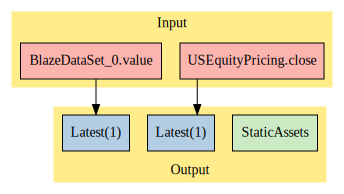

In [17]:
p.show_graph()

In [18]:
df = engine.run_pipeline(
    p,
    pd.Timestamp('2016-01-05', tz='utc'),
    pd.Timestamp('2018-01-04', tz='utc')
)

In [20]:
df.head()

col_A  price
2016-01-05 00:00:00+00:00 Equity(0 [A])    0.909776  40.69
                          Equity(2 [AAL])  0.913870  40.91
2016-01-06 00:00:00+00:00 Equity(0 [A])    0.326422  40.55
                          Equity(2 [AAL])  0.039638  40.52
2016-01-07 00:00:00+00:00 Equity(0 [A])    0.486700  40.73